# Character Level RNN(LSTM) - Name generator - PyTorch

In this network we will train a LSTM(Long short-term memory) RNN(Recurrent Neural Network) with PyTorch. The network will train character by character on some text(i.e) list of names in this scenario, then generate new text character by character. **This model will be able to generate new text based on the text from the input!**

Below are the steps at a higher level:
>1. Install the required packages
2. Import the packages
3. Loading and preprocessing the data
4. Define the LSTM model
5. Train the model
6. Test the trained model

## 1. Install the required packages

In [1]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tqdm
!pip install -U matplotlib
!pip install pandas
!pip install numpy
!pip install unidecode
!pip install regex

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: matplotlib in /opt/conda/lib/python3.7/site-packages (3.3.0)


## 2. Import the packages

Make sure to install all the packages 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [torch](http://pytorch.org) is a library for Python programs that facilitates building deep learning projects.
- [tqdm](https://tqdm.github.io/) is a packge for progress bars with Python. 

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
import datapreprocessor

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 3. Loading and preprocessing the data

First up, we need to get our dataset. 

Our dataset is of csv format. Read the csv file using pandas. Turn the unicode string into plain ASCII. Convert to lower case, trim and remove non-letter characters.

In [3]:
#read the data from csv using pandas
df = pd.read_csv('/data/Sample-Names.csv')
names = df['name'].to_numpy()

# data preprocesser
names = datapreprocessor.normalizeString(names)

#define hyperparameters
batch_size = 64
seq_length = 10

Creating a custom dataset in PyTorch by inheriting Dataset and override the following methods:

- __len__ so that len(dataset) returns the size of the dataset.
- __getitem__ to support the indexing such that dataset can be used to get ith sample

In [4]:
class NamesDataset(Dataset):
    def __init__(self, names, batch_size, seq_length):
        self.names = names
        self.vocab = ' '.join(name for name in names)
        self.int2char, self.char2int, self.n_characters = datapreprocessor.create_lookup_tables(self.vocab)
        self.encoded_vocab = [self.char2int[c] for c in self.vocab]
        self.word_grams = datapreprocessor.build_ngrams(self.encoded_vocab, batch_size, seq_length)

    def __getitem__(self, idx):
        return torch.LongTensor(self.word_grams[idx][0]), torch.LongTensor(self.word_grams[idx][1])#torch.LongTensor

    def __len__(self):
        return len(self.word_grams)

#create dataset object
dataset = NamesDataset(names, batch_size=batch_size, seq_length=seq_length)

Split the dataset into training and validation data

In [5]:
split_frac = 0.8
train_size = int(split_frac * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

Create a dataloader using PyTorch's Dataloader. This has below features. 
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

In [6]:
#create dataloader
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size)

## 4. Define the LSTM model

We will be using LSTM's to train our data character by character and pass the out to the linear layer.

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [7]:
class CharLSTM(nn.Module):
    def __init__(self, n_characters, hidden_size, num_layers, drop_prob=0.5):
        super(CharLSTM, self).__init__()
        self.n_characters = n_characters
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(drop_prob)

        self.LSTM = nn.LSTM(input_size=self.n_characters, hidden_size=self.hidden_size, num_layers=self.num_layers,
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.n_characters)

    def forward(self, inputs, hidden):
        outputs, hidden_out = self.LSTM(inputs, hidden)
        output = self.dropout(outputs)

        output = output.contiguous().view(-1, self.hidden_size)

        output = self.fc(output)

        return output, hidden_out

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device),
                      weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device))

        return hidden

Define the hyperparameters for our model

In [8]:
#hyperparameters
hidden_size = 512
num_layers = 2
output_size = 2
drop_prob=0.5
lr=0.01
num_epochs = 50

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU.

In [9]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = CharLSTM(n_characters=dataset.n_characters, hidden_size=hidden_size,
            num_layers=num_layers, drop_prob=drop_prob).to(device=device)
print(model)

CharLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (LSTM): LSTM(27, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=27, bias=True)
)


## 5. Train the model

In [11]:
def train(model, batch_size, seq_length, lr=0.001, num_epochs=10, clip=5, print_every = 100):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    valid_loss_min = np.Inf # set initial "min" to infinity
    train_losses, valid_losses = [], []

    print("=> Starting training")

    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        train_counter = 0
        hidden = model.init_hidden(batch_size=batch_size)

        progress_bar = tqdm_notebook(train_dataloader, desc='Training', leave=False)
        for inputs, targets in progress_bar:
            if inputs.shape[0] == batch_size:
                train_counter += 1

                inputs = datapreprocessor.one_hot_encode(inputs.numpy(), dataset.n_characters)
                inputs = torch.from_numpy(inputs)

                inputs, targets = inputs.to(device), targets.to(device)

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                hidden = tuple([each.data for each in hidden])

                # Clean old gradients
                model.zero_grad()
                output, hidden = model(inputs, hidden)
                # calculate the loss and perform backprop
                loss = criterion(output, targets.view(batch_size * seq_length).long())
                loss.backward()

                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(model.parameters(), clip)

                optimizer.step()

                train_loss += loss.item()

                if train_counter % print_every == 0:
                    print(f'Epoch: {epoch}/{num_epochs}',
                          "Training Loss: {:.4f}...".format(train_loss/train_counter))
        train_loss = train_loss / train_counter
        train_losses.append(train_loss)
        train_loss = 0

        model.eval()
        valid_progress_bar = tqdm_notebook(valid_dataloader, desc='Validation', leave=False)
        val_hidden = model.init_hidden(batch_size=batch_size)
        valid_counter = 0
        for inputs, targets in valid_progress_bar:
            if inputs.shape[0] == batch_size:
                valid_counter += 1
                inputs = datapreprocessor.one_hot_encode(inputs.numpy(), dataset.n_characters)
                inputs = torch.from_numpy(inputs)

                inputs, targets = inputs.to(device), targets.to(device)

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_hidden = tuple([each.data for each in val_hidden])

                output_val, val_hidden = model(inputs, val_hidden)
                val_loss = criterion(output_val, targets.view(batch_size * seq_length).long())
                valid_loss += val_loss.item()
                if valid_counter % print_every == 0:
                    print(f'Epoch: {epoch}/{num_epochs}',
                          "Validation Loss: {:.4f}...".format(valid_loss/valid_counter))
        valid_loss = valid_loss / valid_counter
        valid_losses.append(valid_loss)
        valid_loss = 0

        model.train()

        print(f'Epoch: {epoch}/{num_epochs}',
              "Training Loss: {:.4f}...".format(np.mean(train_losses)),
              "Val Loss: {:.4f}".format(np.mean(valid_losses)))
        
        # save model if validation loss has decreased
        if np.mean(valid_losses) <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            np.mean(valid_losses)))
            checkpoint = {'hidden_size': model.hidden_size,
                          'num_layers': model.num_layers,
                          'state_dict': model.state_dict()}
            torch.save(checkpoint, 'char_lstm_names_generator.net')
            valid_loss_min = np.mean(valid_losses)
        
    return train_losses, valid_losses

In [12]:
train_losses, valid_losses = train(model, batch_size=batch_size, seq_length=seq_length, num_epochs=num_epochs, lr=lr)

=> Starting training


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch: 1/50 Training Loss: 2.8617...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch: 1/50 Training Loss: 2.7653... Val Loss: 2.4612
Validation loss decreased (inf --> 2.461160).  Saving model ...


Epoch: 2/50 Training Loss: 2.3793...


Epoch: 2/50 Training Loss: 2.5241... Val Loss: 2.2380
Validation loss decreased (2.461160 --> 2.238023).  Saving model ...


Epoch: 3/50 Training Loss: 2.0329...


Epoch: 3/50 Training Loss: 2.3494... Val Loss: 2.1077
Validation loss decreased (2.238023 --> 2.107703).  Saving model ...


Epoch: 4/50 Training Loss: 1.8999...


Epoch: 4/50 Training Loss: 2.2330... Val Loss: 2.0199
Validation loss decreased (2.107703 --> 2.019889).  Saving model ...


Epoch: 5/50 Training Loss: 1.8235...


Epoch: 5/50 Training Loss: 2.1490... Val Loss: 1.9561
Validation loss decreased (2.019889 --> 1.956105).  Saving model ...


Epoch: 6/50 Training Loss: 1.7735...


Epoch: 6/50 Training Loss: 2.0856... Val Loss: 1.9094
Validation loss decreased (1.956105 --> 1.909358).  Saving model ...


Epoch: 7/50 Training Loss: 1.7544...


Epoch: 7/50 Training Loss: 2.0366... Val Loss: 1.8718
Validation loss decreased (1.909358 --> 1.871777).  Saving model ...


Epoch: 8/50 Training Loss: 1.7142...


Epoch: 8/50 Training Loss: 1.9965... Val Loss: 1.8417
Validation loss decreased (1.871777 --> 1.841742).  Saving model ...


Epoch: 9/50 Training Loss: 1.6971...


Epoch: 9/50 Training Loss: 1.9635... Val Loss: 1.8162
Validation loss decreased (1.841742 --> 1.816176).  Saving model ...


Epoch: 10/50 Training Loss: 1.6799...


Epoch: 10/50 Training Loss: 1.9353... Val Loss: 1.7946
Validation loss decreased (1.816176 --> 1.794569).  Saving model ...


Epoch: 11/50 Training Loss: 1.6693...


Epoch: 11/50 Training Loss: 1.9111... Val Loss: 1.7763
Validation loss decreased (1.794569 --> 1.776328).  Saving model ...


Epoch: 12/50 Training Loss: 1.6575...


Epoch: 12/50 Training Loss: 1.8903... Val Loss: 1.7611
Validation loss decreased (1.776328 --> 1.761091).  Saving model ...


Epoch: 13/50 Training Loss: 1.6500...


Epoch: 13/50 Training Loss: 1.8718... Val Loss: 1.7471
Validation loss decreased (1.761091 --> 1.747117).  Saving model ...


Epoch: 14/50 Training Loss: 1.6335...


Epoch: 14/50 Training Loss: 1.8551... Val Loss: 1.7347
Validation loss decreased (1.747117 --> 1.734674).  Saving model ...


Epoch: 15/50 Training Loss: 1.6354...


Epoch: 15/50 Training Loss: 1.8404... Val Loss: 1.7235
Validation loss decreased (1.734674 --> 1.723509).  Saving model ...


Epoch: 16/50 Training Loss: 1.6242...


Epoch: 16/50 Training Loss: 1.8269... Val Loss: 1.7140
Validation loss decreased (1.723509 --> 1.713956).  Saving model ...


Epoch: 17/50 Training Loss: 1.6178...


Epoch: 17/50 Training Loss: 1.8147... Val Loss: 1.7052
Validation loss decreased (1.713956 --> 1.705232).  Saving model ...


Epoch: 18/50 Training Loss: 1.6105...


Epoch: 18/50 Training Loss: 1.8035... Val Loss: 1.6974
Validation loss decreased (1.705232 --> 1.697378).  Saving model ...


Epoch: 19/50 Training Loss: 1.6061...


Epoch: 19/50 Training Loss: 1.7933... Val Loss: 1.6900
Validation loss decreased (1.697378 --> 1.690021).  Saving model ...


Epoch: 20/50 Training Loss: 1.6044...


Epoch: 20/50 Training Loss: 1.7839... Val Loss: 1.6834
Validation loss decreased (1.690021 --> 1.683373).  Saving model ...


Epoch: 21/50 Training Loss: 1.6023...


Epoch: 21/50 Training Loss: 1.7754... Val Loss: 1.6772
Validation loss decreased (1.683373 --> 1.677222).  Saving model ...


Epoch: 22/50 Training Loss: 1.5919...


Epoch: 22/50 Training Loss: 1.7673... Val Loss: 1.6716
Validation loss decreased (1.677222 --> 1.671625).  Saving model ...


Epoch: 23/50 Training Loss: 1.5906...


Epoch: 23/50 Training Loss: 1.7597... Val Loss: 1.6665
Validation loss decreased (1.671625 --> 1.666457).  Saving model ...


Epoch: 24/50 Training Loss: 1.5877...


Epoch: 24/50 Training Loss: 1.7526... Val Loss: 1.6617
Validation loss decreased (1.666457 --> 1.661651).  Saving model ...


Epoch: 25/50 Training Loss: 1.5881...


Epoch: 25/50 Training Loss: 1.7460... Val Loss: 1.6572
Validation loss decreased (1.661651 --> 1.657175).  Saving model ...


Epoch: 26/50 Training Loss: 1.5839...


Epoch: 26/50 Training Loss: 1.7398... Val Loss: 1.6528
Validation loss decreased (1.657175 --> 1.652839).  Saving model ...


Epoch: 27/50 Training Loss: 1.5754...


Epoch: 27/50 Training Loss: 1.7339... Val Loss: 1.6490
Validation loss decreased (1.652839 --> 1.649024).  Saving model ...


Epoch: 28/50 Training Loss: 1.5651...


Epoch: 28/50 Training Loss: 1.7281... Val Loss: 1.6453
Validation loss decreased (1.649024 --> 1.645306).  Saving model ...


Epoch: 29/50 Training Loss: 1.5780...


Epoch: 29/50 Training Loss: 1.7229... Val Loss: 1.6417
Validation loss decreased (1.645306 --> 1.641694).  Saving model ...


Epoch: 30/50 Training Loss: 1.5779...


Epoch: 30/50 Training Loss: 1.7179... Val Loss: 1.6384
Validation loss decreased (1.641694 --> 1.638436).  Saving model ...


Epoch: 31/50 Training Loss: 1.5698...


Epoch: 31/50 Training Loss: 1.7132... Val Loss: 1.6355
Validation loss decreased (1.638436 --> 1.635493).  Saving model ...


Epoch: 32/50 Training Loss: 1.5595...


Epoch: 32/50 Training Loss: 1.7087... Val Loss: 1.6326
Validation loss decreased (1.635493 --> 1.632565).  Saving model ...


Epoch: 33/50 Training Loss: 1.5653...


Epoch: 33/50 Training Loss: 1.7044... Val Loss: 1.6299
Validation loss decreased (1.632565 --> 1.629948).  Saving model ...


Epoch: 34/50 Training Loss: 1.5500...


Epoch: 34/50 Training Loss: 1.7002... Val Loss: 1.6274
Validation loss decreased (1.629948 --> 1.627394).  Saving model ...


Epoch: 35/50 Training Loss: 1.5573...


Epoch: 35/50 Training Loss: 1.6962... Val Loss: 1.6248
Validation loss decreased (1.627394 --> 1.624840).  Saving model ...


Epoch: 36/50 Training Loss: 1.5630...


Epoch: 36/50 Training Loss: 1.6924... Val Loss: 1.6226
Validation loss decreased (1.624840 --> 1.622603).  Saving model ...


Epoch: 37/50 Training Loss: 1.5565...


Epoch: 37/50 Training Loss: 1.6888... Val Loss: 1.6203
Validation loss decreased (1.622603 --> 1.620338).  Saving model ...


Epoch: 38/50 Training Loss: 1.5556...


Epoch: 38/50 Training Loss: 1.6853... Val Loss: 1.6183
Validation loss decreased (1.620338 --> 1.618318).  Saving model ...


Epoch: 39/50 Training Loss: 1.5586...


Epoch: 39/50 Training Loss: 1.6819... Val Loss: 1.6162
Validation loss decreased (1.618318 --> 1.616229).  Saving model ...


Epoch: 40/50 Training Loss: 1.5471...


Epoch: 40/50 Training Loss: 1.6787... Val Loss: 1.6145
Validation loss decreased (1.616229 --> 1.614526).  Saving model ...


Epoch: 41/50 Training Loss: 1.5469...


Epoch: 41/50 Training Loss: 1.6754... Val Loss: 1.6128
Validation loss decreased (1.614526 --> 1.612811).  Saving model ...


Epoch: 42/50 Training Loss: 1.5437...


Epoch: 42/50 Training Loss: 1.6724... Val Loss: 1.6112
Validation loss decreased (1.612811 --> 1.611186).  Saving model ...


Epoch: 43/50 Training Loss: 1.5418...


Epoch: 43/50 Training Loss: 1.6696... Val Loss: 1.6096
Validation loss decreased (1.611186 --> 1.609563).  Saving model ...


Epoch: 44/50 Training Loss: 1.5448...


Epoch: 44/50 Training Loss: 1.6668... Val Loss: 1.6079
Validation loss decreased (1.609563 --> 1.607948).  Saving model ...


Epoch: 45/50 Training Loss: 1.5412...


Epoch: 45/50 Training Loss: 1.6641... Val Loss: 1.6064
Validation loss decreased (1.607948 --> 1.606396).  Saving model ...


Epoch: 46/50 Training Loss: 1.5434...


Epoch: 46/50 Training Loss: 1.6615... Val Loss: 1.6049
Validation loss decreased (1.606396 --> 1.604942).  Saving model ...


Epoch: 47/50 Training Loss: 1.5445...


Epoch: 47/50 Training Loss: 1.6590... Val Loss: 1.6036
Validation loss decreased (1.604942 --> 1.603560).  Saving model ...


Epoch: 48/50 Training Loss: 1.5429...


Epoch: 48/50 Training Loss: 1.6566... Val Loss: 1.6023
Validation loss decreased (1.603560 --> 1.602266).  Saving model ...


Epoch: 49/50 Training Loss: 1.5419...


Epoch: 49/50 Training Loss: 1.6543... Val Loss: 1.6012
Validation loss decreased (1.602266 --> 1.601162).  Saving model ...


Epoch: 50/50 Training Loss: 1.5308...


Epoch: 50/50 Training Loss: 1.6520... Val Loss: 1.5999
Validation loss decreased (1.601162 --> 1.599919).  Saving model ...


### Plot the training and validation set losses

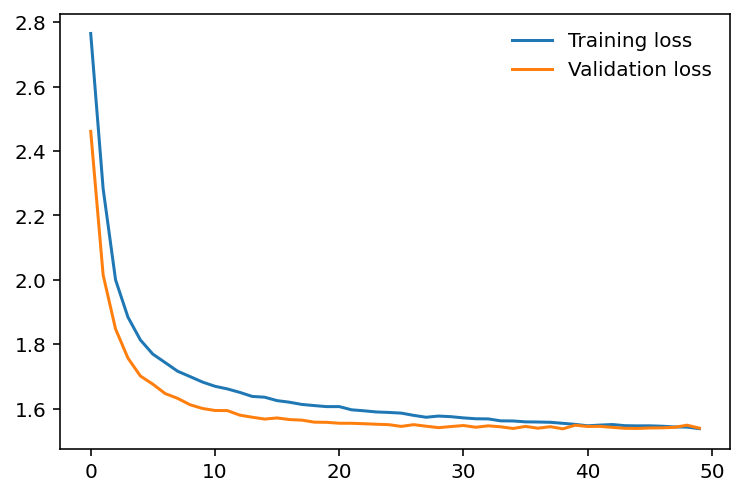

In [13]:
# plot the cost
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Checkpoint

After training, we'll save the model so we can load it again later if we need too. Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters.

In [14]:
# change the name, for saving multiple files
model_name = 'char_lstm_names_generator.net'

checkpoint = {'hidden_size': model.hidden_size,
              'num_layers': model.num_layers,
              'state_dict': model.state_dict()}

#with open(model_name, 'wb') as f:
    #torch.save(checkpoint, f)

## 6. Test the trained model

- predict - function which take the character as input and finds the next probable character using the saved model and hidden state. 

In [15]:
def predict(model, char, h=None, top_k=None):
    x = np.array([[dataset.char2int[char]]])
    x = datapreprocessor.one_hot_encode(x, dataset.n_characters)
    inputs = torch.from_numpy(x).to(device)

    # detach hidden state from history
    h = tuple([each.data for each in h])
    
    #
    out, h = model(inputs, h)

    out = nn.functional.softmax(out, dim=1).data
    if torch.cuda.is_available():
        out = out.cpu()

    # get top characters
    if top_k is None:
        top_ch = np.arange(dataset.n_characters)
    else:
        out, top_ch = out.topk(top_k)
        top_ch = top_ch.numpy().squeeze()

    # select the likely next character with some element of randomness
    out = out.numpy().squeeze()
    out_char = np.random.choice(top_ch, p=out/out.sum())

    # return the encoded value of the predicted char and the hidden state
    return dataset.int2char[out_char], h

In [29]:
##generate the names
def generate_output(model, initial_str='a', predict_len=100, top_k=None):
    initial_str = datapreprocessor.unicodeToAscii(str(initial_str).lower().strip())
    
    model.eval()

    h = model.init_hidden(batch_size=1)

    input_chars = [ch for ch in initial_str]

    for ch in initial_str:
        char_out, h = predict(model, ch, h, top_k=top_k)

    input_chars.append(char_out)

    for counter in range(predict_len):
        char_out, h = predict(model, input_chars[-1], h, top_k=top_k)
        input_chars.append(char_out)

    return ''.join(input_chars)

In [30]:
checkpoint = torch.load('char_lstm_names_generator.net')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [32]:
print(generate_output(model, 'Bal', top_k=5))

balrem rajesh chawal rahul sahil suraj ram pandey ashish pal malik ashok kumar sahu amar rajesh rah anil


### Happy Learning!!!